In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pyclugen import clugen
from mynn import categ2oneofn

2025-12-09 21:24:49.805632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


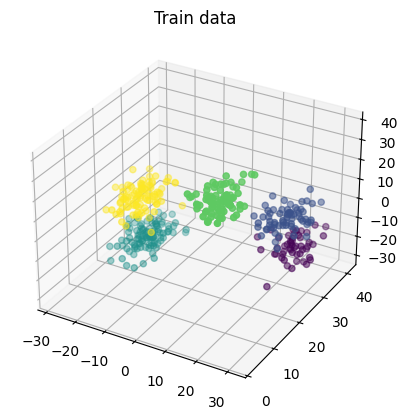

In [2]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=np.random.default_rng(seed),
)

# Plot the train data
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
ax.set_title("Train data");

In [3]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)

In [4]:
# Weight initializer
unif_winit = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=123)

# Using Sequential() to build layers one after another
model = tf.keras.Sequential(
    [
        # Input layer
        tf.keras.layers.Input(shape=(ndims,)),
        # Hidden Layer with 12 units and sigmoid activation
        tf.keras.layers.Dense(
            units=18,
            activation="sigmoid",
            kernel_initializer=unif_winit,
        ),
        # Hidden Layer with 12 units and sigmoid activation
        tf.keras.layers.Dense(
            units=18,
            activation="sigmoid",
            kernel_initializer=unif_winit,
        ),
        # Output Layer with 5 units for 5 classes and sigmoid activation
        tf.keras.layers.Dense(
            units=nclu,
            activation="sigmoid",
            kernel_initializer=unif_winit,
        ),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.25),
    metrics=["accuracy"],
)

I0000 00:00:1765315492.963510   69484 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4684 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [5]:
history = model.fit(
    x=data_train.points,
    y=clunn_train,
    epochs=300,
    batch_size=1,
    shuffle=False,
)

Epoch 1/300


2025-12-09 21:24:53.863781: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ea234002c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 21:24:53.863793: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-12-09 21:24:53.890448: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 21:24:53.934236: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


182/400 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.6606 - loss: 0.1145  

I0000 00:00:1765315494.117131   69576 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.5175 - loss: 0.0933
Epoch 2/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.4000 - loss: 0.0933
Epoch 3/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.3925 - loss: 0.0941
Epoch 4/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.3900 - loss: 0.0942
Epoch 5/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.3900 - loss: 0.0941
Epoch 6/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.3900 - loss: 0.0940
Epoch 7/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.3925 - loss: 0.0938
Epoch 8/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.3975 - loss: 0.0935
Epoch 9/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.4025 - loss: 0.0928
Epoch 10/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.4175 - loss: 0.0917
Epoch 11/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.4400 - loss: 0.0897
Epoch 12/300
400/400 ━━━━━━━━━━

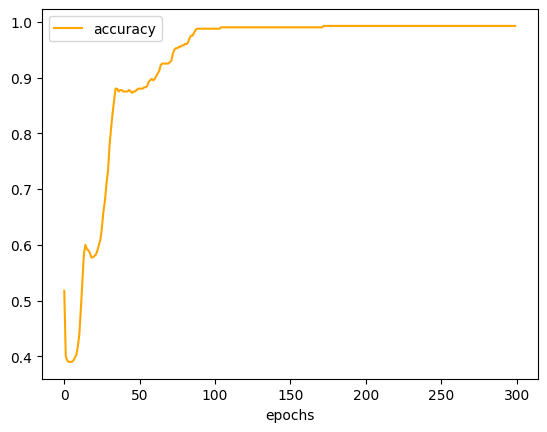

In [ ]:
# Showing plot for accuracy
plt.plot(history.history['accuracy'], color='orange')
plt.xlabel('epochs')
plt.legend(['accuracy'])

In [9]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.
